This is a new code to replot the model domain in planview, hopefully in a way that looks nicer

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import csv
import os
import scipy
import scipy.stats as stats
import seaborn as sns
import math 
import matplotlib.animation as animation
import matplotlib.colors as mcol
import matplotlib.cm as cm
import time
import random
import statistics as stat
from scipy.stats import variation
from xml.dom import minidom


from scipy import interpolate
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import LineCollection
from matplotlib.collections import PolyCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.colors import LinearSegmentedColormap
from IPython.display import HTML
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)


from mpl_toolkits.mplot3d import Axes3D

import sgolay2

#plt.rcParams['animation.ffmpeg_path'] = '/opt/local/bin/ffmpeg'
# %matplotlib inline
#%matplotlib qt

In /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mpl

ModuleNotFoundError: No module named 'sgolay2'

In [ ]:
def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]

def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mcol.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp

In [2]:
# x, y = np.mgrid[-5:5:0.05, -5:5:0.05]
# z = (np.sqrt(x**2 + y**2) + np.sin(x**2 + y**2))
# test = ['a75e09','bd6c48', 'af884a', 'cb7723','7bc8f6','0e87cc', '2242c77', '0504aa','0504aa', '00035b'] 
test = ['a75e09','bd6c48', 'af884a', 'cb7723','7bc8f6','069af3', '0e87cc', '2242c77', '0504aa','0504aa', '00035b', '020035'] 

#test = ['96e821','90992b', 'dc983d', 'efb763', '0e87cc','062029']#,'062029']#,'062029','062029']#,'069af3', '0e87cc', '2242c77', '0504aa', '00035b'] from satellite images
#test = ['062029', '062029', '0e87cc', 'efb763', 'dc983d', '90992b', '96e821']
centrelines = ['ffffff', '000000']

In [3]:
Q = str(100)# discharge in m3/s
slope = 0.00137#gradient

d50 = 0.31e-3 #d50 grain size in m
# iloc = 300 #location of the section along i axis
# jloc = 14#location of the secion along j axis
# thot_SS = 820800 #
# #time from which we restarted the runs to add a flood
# fldstart_s = 3600 ##start time of flood in seconds
fldlength = 0
idf = '0hfld' #identifier/classifier about the flood setting
intstring = '2hour' #time interval of output
nickname = 'agubh2-10km' #model nickname, agubh2, gentle_wide etc
floodname ='_0hrflood'

datnam = f'{idf}-datamaster-{intstring}-ud.npy' #name of the data file to upload
dataloc = f'data-{nickname}{floodname}' #where csv files are
arrayfolder = f'c-{idf}-{nickname}' #where raw centroid data array stored
mainsurfto = f'ms-{idf}-{nickname}' #where bounding surfaces array will go
iricoutputt =600 #output time from the model, s
cellW = 4
cellL = 10
# xloc = iloc*cellW
# xsloc = iloc*cellL
#print(xsloc)
spacing = 1 #spacing of cross stream x locations, m


ps = 2650 # bulk density of quartz kg/m3
p = 1000 # density of water in kg/m3
nu = 1.787*10e-6 #kinematic viscosity of water in m2/s
nu=1.0533e-6

In [4]:
font = {'family' : 'Helvetica',
        'weight' : 'normal',
        'size'   : 8}

mpl.rc('font', **font)
#mpl.rc('axes',  edgecolor='w')

In [5]:
print(f'/Volumes/SAF_Data/NAYS2DH_files/Data/ConvertedArrays/{dataloc}/{datnam}')
datamaster = np.load(f'/Volumes/SAF_Data/NAYS2DH_files/Data/ConvertedArrays/{dataloc}/{datnam}', allow_pickle = True)

#savefilesto = '/Volumes/SAF_MSCWORK/Python/Stratigraphy/Plots/'
# modelrun = f'{nickname}-hr-{fldlength}hrfld-{iloc}'
modelrun = f'{nickname}-hr-{fldlength}hrfld-pf'

##define grid dimensions
gridx = 1001
gridy = 26

datacond = 1
if datacond == 1:
    cells = gridy
else:
    cells = gridx
length = 1001 #length of the domain in the x direction
erostart = 5
erostop = 5
uprbd = 0
lwrbd= 1000
print('Shape of the datamaster dataset is: ', datamaster.shape)
savefilesto = (f'/Volumes/SAF_Data/NAYS2DH_files/Plots/videos/vid-{lwrbd}-{idf}-{nickname}')

/Volumes/SAF_Data/NAYS2DH_files/Data/ConvertedArrays/data-agubh2-10km_0hrflood/0hfld-datamaster-2hour-ud.npy
Shape of the datamaster dataset is:  (26026, 11, 382)


In [6]:
num_timesteps = datamaster.shape[2] ## or 168 for 2 weeks# len(os.listdir(filepathcore))-1 ##when u want to stop plotting
print('Number of timesteps being used: ', num_timesteps)
datamaster = datamaster[:, :, :num_timesteps]
# position = np.arange(0, length, dtype = float)
# coevelev = np.empty([num_timesteps])
interval_to_plot = 120/60 #we want to plot every ___  HOURS 
end_t = num_timesteps #len(np.arange(1, num_timesteps, skipstep)) #number of timesteps in data master array
# fldstart = ((thot_SS+fldstart_s)/3600)/interval_to_plot ##flood starttime, s

# print('Shape of data used to plot:', datamaster.shape)

Number of timesteps being used:  382


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1720: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


attribute top: 1.33. Midpoint: 0.82
0.0 7.98981159484


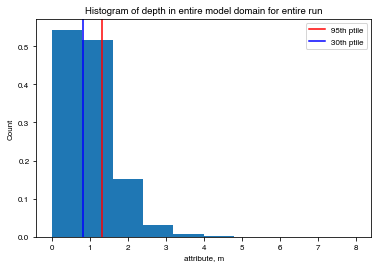

In [7]:
#create 2D grid
#extract elevation

char = 4 ## what do you want to colour by? flow depth (4), elevation change (7), velocity (10) etc
attribs = datamaster[:, char, :].ravel() # scaling to find your normalisation for the attribute/char you choose to colour with
avattribs = np.average(attribs)
locd = np.average(avattribs)
scd = np.std(avattribs)
attx = np.linspace(attribs.min(), attribs.max())
apdf = stats.norm.pdf(attx, locd, scd)
plt.hist(attribs, density=True);

toplim = np.quantile(attribs, 0.75) ##was initally .45 and .65 of velocity
lowlim = np.quantile(attribs, 0.45)
plt.axvline(toplim, c = 'r', label = '95th ptile')
plt.axvline(lowlim, c = 'b', label = '30th ptile')
plt.xlabel('attribute, m')
plt.ylabel('Count')
plt.legend()
plt.title('Histogram of depth in entire model domain for entire run');
print(f'attribute top: {np.round(toplim, 2)}. Midpoint: {np.round(lowlim, 2)}')
post_idx = -1

xdomain = np.reshape(datamaster[:, 2, -1], (gridy, gridx))
ydomain = np.reshape(datamaster[ :, 3, -1] , (gridy, gridx))
#elev_final = np.reshape(datamaster[:, char, -1], (gridy, gridx)) ##using flow depth to plot
#elev_pref = np.reshape(datamaster[:, char, pref_idx], (gridy, gridx)) ##using flow depth to plot
elev_postf = np.reshape(datamaster[:, char, post_idx], (gridy, gridx)) ##using flow depth to plot

llim = datamaster[:, 3, :].min()
ulim = datamaster[:, 3, :].max()

#find the max and min of the variable you're plotting to scale the colourmap
var_llim = datamaster[:, char, :].min() 
var_ulim = datamaster[:, char, :].max()
print(var_llim, var_ulim)


In [8]:
class MidpointNormalize(mcol.Normalize):
    def __init__(self, vmin=None, vmax=None, vcenter=None, clip=False):
        self.vcenter = vcenter
        mcol.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.vcenter, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

#normalise = plt.Normalize(-1, 2)
#midnorm = MidpointNormalize(vmin=-np.quantile(datamaster[:, 4, :], 0.1), vcenter=0.5, vmax=np.quantile(datamaster[:, 4, :], 0.99))
#midnorm = MidpointNormalize(vmin=0, vcenter=np.quantile(datamaster[:, char, :], .25), vmax=np.quantile(datamaster[:, char, :], .999)) 
#midnorm = MidpointNormalize(vmin=0, vcenter=lowlim, vmax=toplim) 
#midnorm = MidpointNormalize(vmin = np.quantile(datamaster[:, 7, :], 0.01), vcenter = 0, vmax = np.quantile(datamaster[:, 7, :], 0.99))
midnorm = MidpointNormalize(vmin = 0, vcenter = lowlim, vmax = toplim)
# midnorm = MidpointNormalize(vmin = 0, vcenter = 0.3, vmax = 2)

In [9]:
xlocs = np.reshape(datamaster[ :, 2, :] , (gridy, gridx, end_t))
ylocs = np.reshape(datamaster[ :, 3, :] , (gridy, gridx, end_t)) 
bedelev = np.reshape(datamaster[:, 7, :], (gridy, gridx, end_t))
depth = np.reshape(datamaster[:, 4, :], (gridy, gridx, end_t))
velo = np.reshape(datamaster[:, 10, :], (gridy, gridx, end_t))
# bankwidth = ylocs[-1, :]-ylocs[0, :]
# rowdim = math.ceil(bankwidth.max())
# print(rowdim)

In [10]:
centrey = abs(datamaster[ :, 3, -1].min())

In [11]:
rightmost_y = np.floor(ylocs.min())
ylocs = ylocs-rightmost_y
ylocs = ylocs.astype(int)

In [12]:
# bedelev = ['a75e09','bd6c48', '0e87cc', '0504aa','040273', '020035', '001146'] 
# twocols = ['#d1b26f', '#010fcc']
# cmap = mcol.LinearSegmentedColormap.from_list('two', twocols[::-1])
# twonorm = mcol.BoundaryNorm([0, 1.5, 4], cmap.N)
plt.figure(figsize = (12, 3), dpi = 200)
# bed = plt.pcolormesh(xlocs, ylocs, np.ma.array(bed_savgol, mask = bed_savgol<1), cmap = 'ocean_r', norm = mcol.Normalize (vmin = 0, vmax = 4.5))
# bed = plt.pcolormesh(xlocs, ylocs, np.ma.array(bed_savgol, mask = bed_savgol<1), cmap = 'ocean_r', norm = mcol.Normalize (vmin = 0, vmax = 4.5))
disch = plt.pcolormesh(xlocs, ylocs, np.multiply(velo, depth), cmap = get_continuous_cmap(test), norm = mcol.TwoSlopeNorm(vmin = 0, vcenter = .5, vmax = np.nanmax(hd_qw)), shading = 'nearest')
# water = plt.pcolormesh(xlocs, ylocs, dep_savgol, cmap = get_continuous_cmap(test), norm = mcol.PowerNorm(gamma = .95))

# plt.colorbar(bed, shrink = .25, aspect = 5)
plt.colorbar(water, shrink = .25, aspect = 5)
ax = plt.gca()
ax.set_aspect('equal')

# ax.set_ylim(-250, 250)
# ax.set_xlim(3000, 3500)


NameError: name 'get_continuous_cmap' is not defined

<Figure size 2400x600 with 0 Axes>

NameError: name 'ztest' is not defined

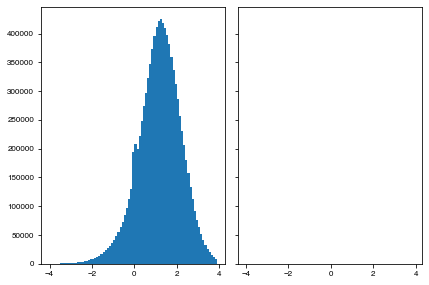

In [13]:
fig, ax = plt.subplots(1, 2, sharex = True, sharey = True, tight_layout = True)
ax[0].hist(bedelev.ravel(), bins = np.arange(-4, 4, .1));
ax[1].hist(ztest.ravel(), bins = np.arange(-4, 4, .1));

## fit different filter to the stratigraphy

In [16]:
path = '/Volumes/SAF_Data/NAYS2DH_files/Data/nparrays/fullbed-interp/'

In [9]:
hd_xlocs = np.load('/Users/safiya/Desktop/xpos.npy', allow_pickle = True)
hd_ylocs = np.load('/Users/safiya/Desktop/ypos.npy', allow_pickle = True)
hd_depth = np.load('/Users/safiya/Desktop/depth.npy', allow_pickle = True)
hd_velo = np.load('/Users/safiya/Desktop/velocity.npy', allow_pickle = True)

NameError: name 'hd_elev' is not defined

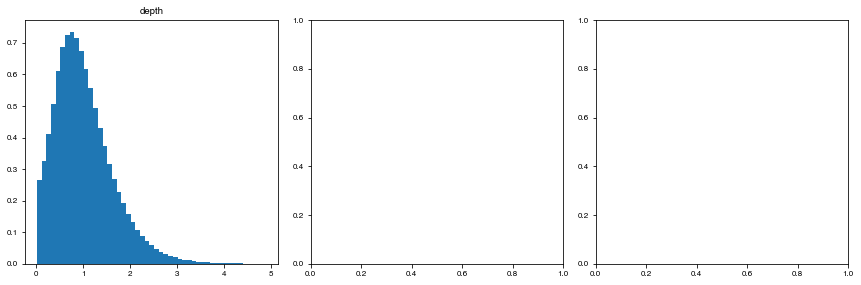

In [11]:
fig, ax = plt.subplots(1, 3, figsize = (12, 4), tight_layout = True)
ax[0].hist(hd_depth.ravel(), bins = np.arange(0.01, 5, 0.1), density = True);
ax[0].set_title('depth');

ax[1].hist(hd_elev.ravel(), bins = np.arange(-4, 4, 0.1), density = True);
ax[1].set_title('elev')

ax[1].vlines([np.nanpercentile(hd_elev, [1, 10, 99])], ymin = 0, ymax = 0.5)

ax[2].hist(hd_velo.ravel(), bins = np.arange(0, 3, 0.1), density = True);
ax[2].set_title('velo')
ax[2].axvline(np.nanmean(hd_velo))

Trying to make a function to fit the colourmap to the data better <br>
Using PB gamma PDF

In [34]:
# 'a75e09','bd6c48', 'af884a', 'cb7723',
realtest = ['a75e09', 'cb7723','069af3', '0e87cc', '2242c77', '0504aa','0504aa', '00035b', '020035', '040348'] 

# test = ['a75e09','bd6c48', '0e87cc', '2242c77', '0504aa','040273', '00035b', '020035'] 
ai_swatch = ['6e4b26', '6c4222', 'ba8952', 'f5c58c', '3d9ad2', '3b67ac', '243d6c', '263368']

In [199]:
ylocs.shape

(26, 1001)

In [306]:
ylocs[:, 300:340].max()

550

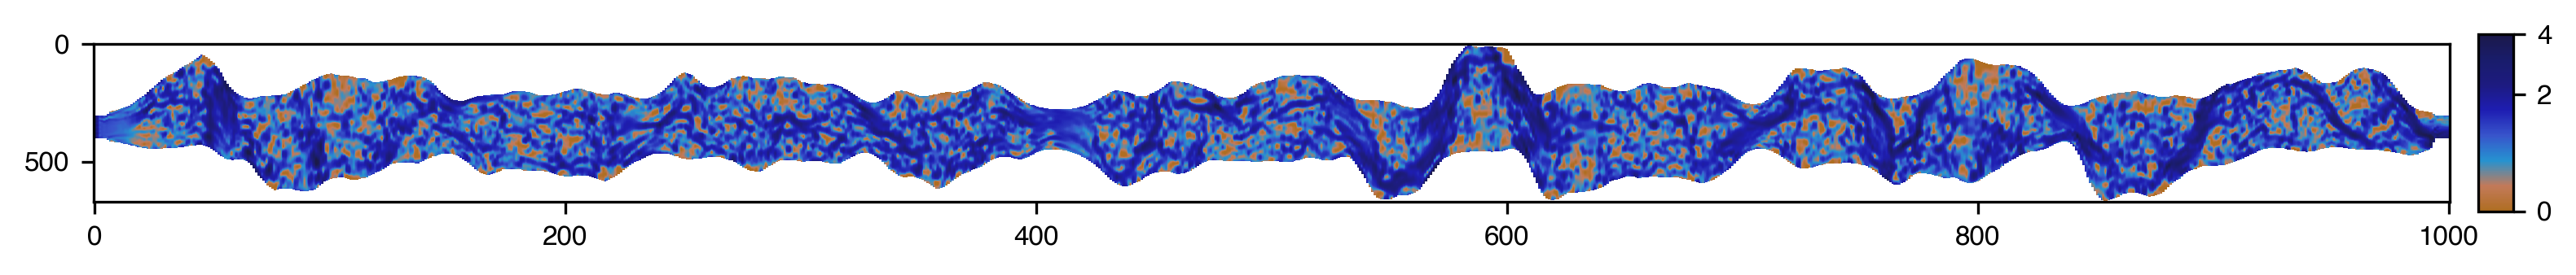

In [205]:
centreline = 100
plt.figure(figsize = (12, 7.5), tight_layout = True, dpi = 300)
depth_plot = plt.imshow(hd_depth, cmap = get_continuous_cmap(test), norm = mcol.TwoSlopeNorm(vmin = 0.0, vcenter = np.nanmean(hd_depth), vmax = 4), alpha = 0.9)
# plt.ylim(ylocs[:, 300:340].min(), ylocs[:, 300:340].min()+250)
# plt.xlim(300, 350)
ax = plt.gca()
ax.set_aspect(0.1)
fig.colorbar(depth_plot, ax= ax, shrink =.1, aspect = 5, pad = 0.01)
# plt.savefig('/Users/safiya/Desktop/BarManuscript_2022-local/figs/340stretch_cropped-planform.png', dpi = 300, transparent = True)

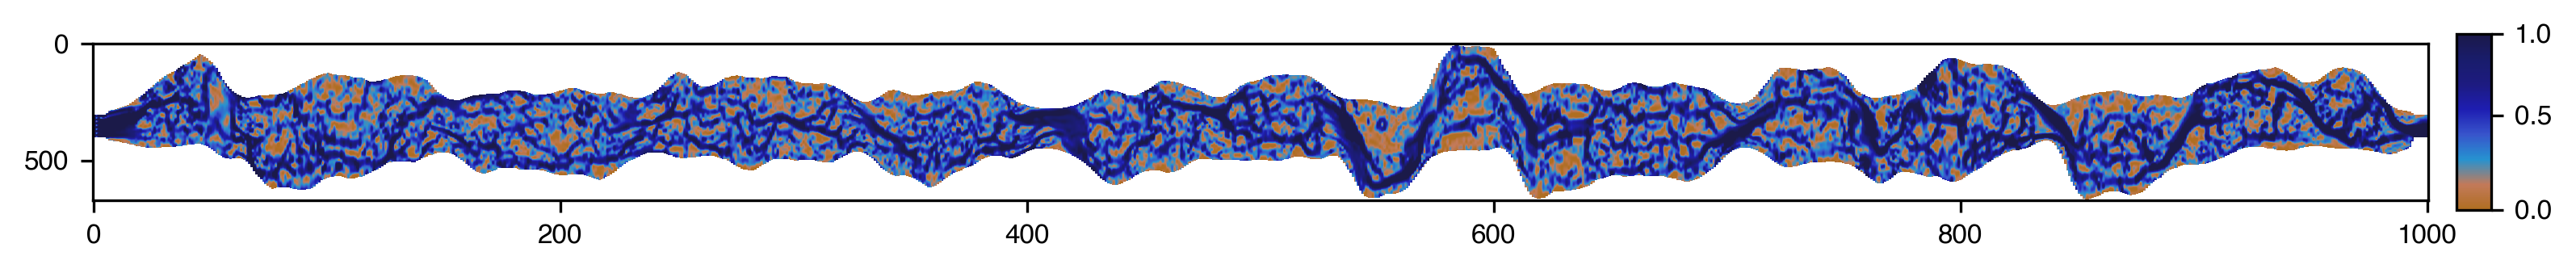

In [318]:
plt.figure(figsize = (12, 7.5), tight_layout = True, dpi = 300)
depth_plot = plt.imshow(hd_velo, cmap = get_continuous_cmap(test), norm = mcol.TwoSlopeNorm(vmin = 0.0, vcenter = np.nanmean(hd_velo), vmax = 1), alpha = 0.9)
# plt.ylim(ylocs[:, 300:340].min(), ylocs[:, 300:340].min()+250)
# plt.xlim(300, 350)
ax = plt.gca()
ax.set_aspect(0.1)
fig.colorbar(depth_plot, ax= ax, shrink =.1, aspect = 5, pad = 0.01)

In [196]:
# bedcols = ['00035b', '0504aa', '040273', '2242c77', '0e87cc', 'bd6c48', 'a75e09', 'fdaa48']
bedcols = ['030aa7', '0504aa', '040273', 'bd6c48', 'a75e09', 'e17701']
bedbounds = np.nanpercentile(hd_elev, [1, 50, 99])
bedtest = test[::-1]
print(bedtest)
# bedbounds = [-4, 0, 4]
bedcmap = mcol.ListedColormap(bedcols)
binary = mcol.BoundaryNorm(boundaries = bedbounds, ncolors = len(bedcols))
bedbounds

['020035', '00035b', '0504aa', '0504aa', '2242c77', '0e87cc', 'bd6c48', 'a75e09']


array([-1.46293598,  1.55069863,  3.74488857])

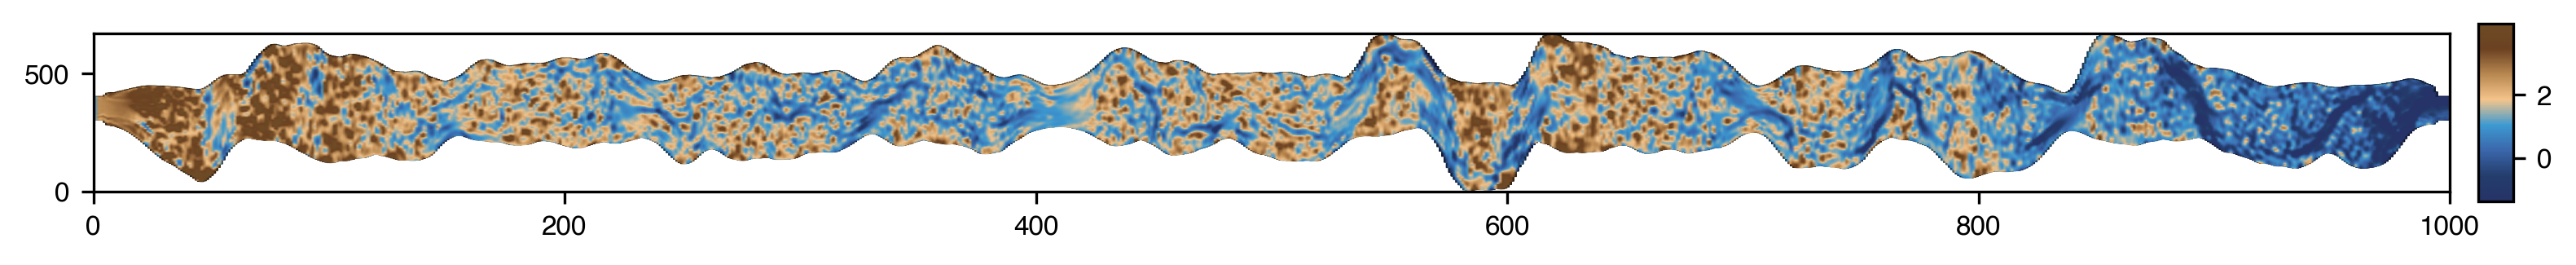

In [197]:
centreline = 100
plt.figure(figsize = (12, 7.5), tight_layout = True, dpi = 300)
bed_plot = plt.pcolormesh(hd_xlocs, hd_ylocs, hd_elev, norm = mcol.TwoSlopeNorm(vmin = bedbounds[0], vcenter = bedbounds[1], vmax = bedbounds[2]), cmap = get_continuous_cmap(ai_swatch[::-1]), alpha =1, shading = 'gouraud')#, interpolation = 'nearest')
# plt.ylim(ylocs[:, 300:340].min(), ylocs[:, 300:340].min()+250)
# plt.xlim(300, 350)
ax = plt.gca()
ax.set_aspect(0.1)
fig.colorbar(bed_plot, ax= ax, shrink = 0.1, aspect = 5, pad =0.01)
# plt.savefig('/Users/safiya/Desktop/BarManuscript_2022-local/figs/340stretch_cropped-planform.png', dpi = 300, transparent = True)

In [224]:
np.nanmax(hd_velo)

3.936610966904666

### DO NOT EDIT THIS CELL!!!!

In [43]:
newtest = ['ab7e4c', '964e02', '31668a', '021bf9', '0c1793', '2000b1', '030764', '040348', '070d0d']

In [23]:
test = ['a75e09','bd6c48', '0e87cc', '3778bf', '2242c77', '0504aa','040273', '020035', '000000'] 

In [138]:
test = ['a75e09','bd6c48', '0e87cc', '2242c77', '0504aa','040273', '00035b', '020035', '001146'] 

plt.figure(figsize = (12, 3.5), tight_layout = True, dpi = 300)

depth_plot = plt.imshow(hd_depth, cmap = get_continuous_cmap(test), norm = mcol.TwoSlopeNorm(vmin = 0.0, vcenter = np.nanmean(hd_depth), vmax = 4), alpha = 0.75)
ax = plt.gca()
fig.colorbar(depth_plot, ax= ax, shrink =.1, aspect = 5, pad = 0.001)
# vel_plot = ax.imshow(hd_velo, cmap = get_continuous_cmap(test), norm = mcol.TwoSlopeNorm(vmin = 0.0, vcenter = np.nanmean(hd_velo), vmax = np.nanmax(hd_velo)), alpha = 0.75)

fig.colorbar(vel_plot, ax= ax, shrink =.1, aspect = 5, pad = 0.01)



# plt.savefig('/Users/safiya/Desktop/BarManuscript_2022-local/figs/Planform-from-GOD.png', transparent = True, dpi = 400)

NameError: name 'hd_depth' is not defined

<Figure size 3600x1050 with 0 Axes>

In [175]:
ai_swatch = ['6e4b26', '6c4222', 'ba8952','f5c58c', '3d9ad2', '3b67ac', '243d6c', '263368']

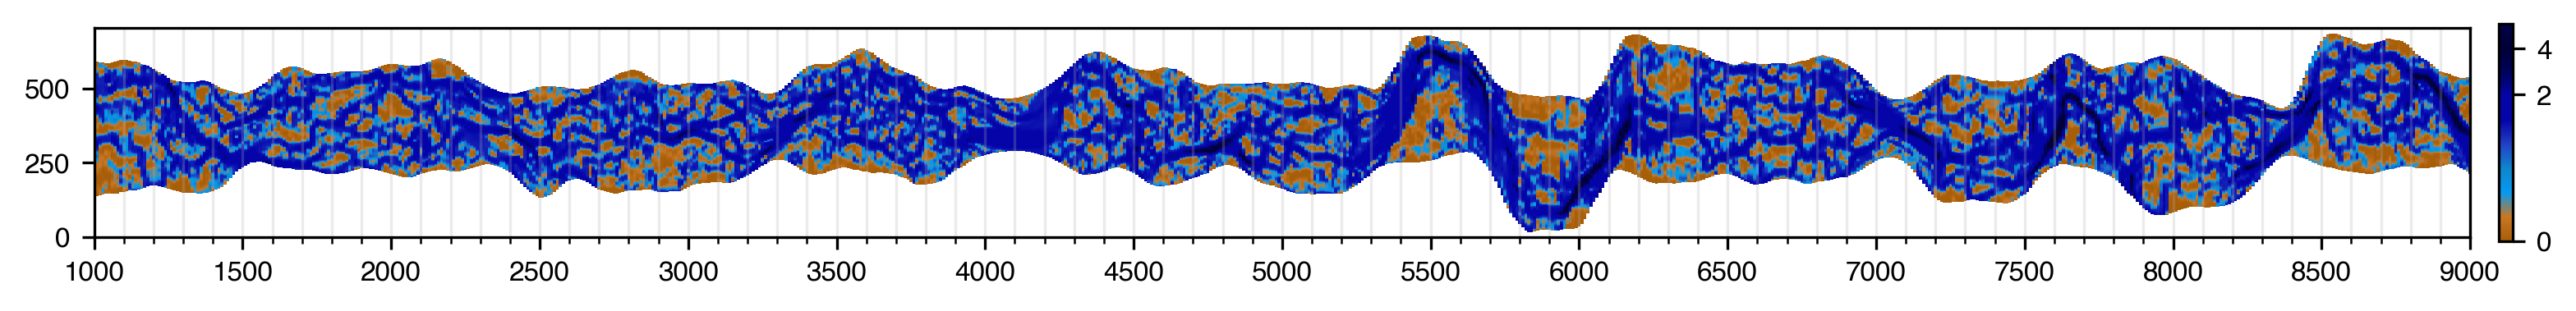

In [45]:
# colorgraph = ["#d95e13", "#382010", "#4ea6dc", "#1a6587", "#be9672", "#78583e"]
# colorgraph = ['#002467', '#075ba8', '#804e39', '#4d220f']

# hd_qw = np.multiply(hd_depth, hd_velo) 

## can add bed elevation at low velocity areas
# plt.hist(hd_qw.ravel(), bins = np.arange(0, 4, 0.25));
# plt.axvline(np.nanmedian(hd_qw))
# plt.figure(figsize = (12, 3.5), tight_layout = True, dpi = 300)
fig = plt.figure(figsize = (12, 12), tight_layout = True, dpi = 300)
thr = .2
ts = 381
qw_plot = plt.pcolormesh(hd_xlocs[:, :, ts]*10, hd_ylocs[:, :, ts], hd_qw[:, :, ts], cmap = get_continuous_cmap(realtest), norm = mcol.TwoSlopeNorm(vmin = 0, vcenter = .35, vmax = np.nanquantile(hd_qw[:, :, -1], 0.999)))
# qw_plot = plt.pcolormesh(hd_xlocs*10, hd_ylocs, np.ma.array(hd_qw, mask = hd_qw<=thr), cmap = get_continuous_cmap(test), norm = mcol.TwoSlopeNorm(vmin = 0, vcenter = .5, vmax = np.nanmax(hd_qw)))
# # qw_plot = plt.imshow(np.ma.array(hd_elev, mask = hd_qw>=thr+.2), cmap = 'copper', norm = mcol.TwoSlopeNorm(vmin = -4, vcenter = 0, vmax = 10))
# qw_plot = plt.pcolormesh(hd_xlocs*10, hd_ylocs, np.ma.array(hd_elev, mask = hd_qw>=thr), cmap = 'copper', norm = mcol.Normalize(vmin = -2, vmax = 10), shading = 'gouraud')
ax = plt.gca()
ax.set_aspect('equal')
ax.set_xlim(1000, 9000)
# ax.set_ylim(centrey-abs(datamaster[ :, 3, -1].min()), centrey+100)
ax.set_ylim(hd_ylocs.min(), hd_ylocs.max())
ax.xaxis.set_minor_locator(MultipleLocator(100))
ax.xaxis.set_major_locator(MultipleLocator(500))
ax.grid(axis = 'x', which = 'both', alpha = 0.25)
# ax.set_xlabel('Downstream distance, m')
# ax.set_ylabel('Cross-stream\n distance, m')
# fig.colorbar(qw_plot, ax= ax, shrink =.075, aspect = 15, pad = 0.01)
# plt.savefig('/Users/safiya/Desktop/BarManuscript_2022-local/figs/Planform-4-ai.png', transparent = True, dpi = 200)
# plt.savefig('/Users/safiya/Desktop/BarManuscript_2022-local/figs/Planform-feb-fnl.png', transparent = True, dpi = 200)
# plt.savefig('/Users/safiya/Desktop/BarManuscript_2022-local/figs/Planform-cbar.png', transparent = True, dpi = 300)

for illustrator

Playing with aggradation rates

In [37]:
np.append(np.arange(adjustment_time, end_t+1, adjustment_time), end_t)

array([ 65, 130, 195, 260, 325, 381])

In [26]:
adjustment_time = 65
end_t = 381

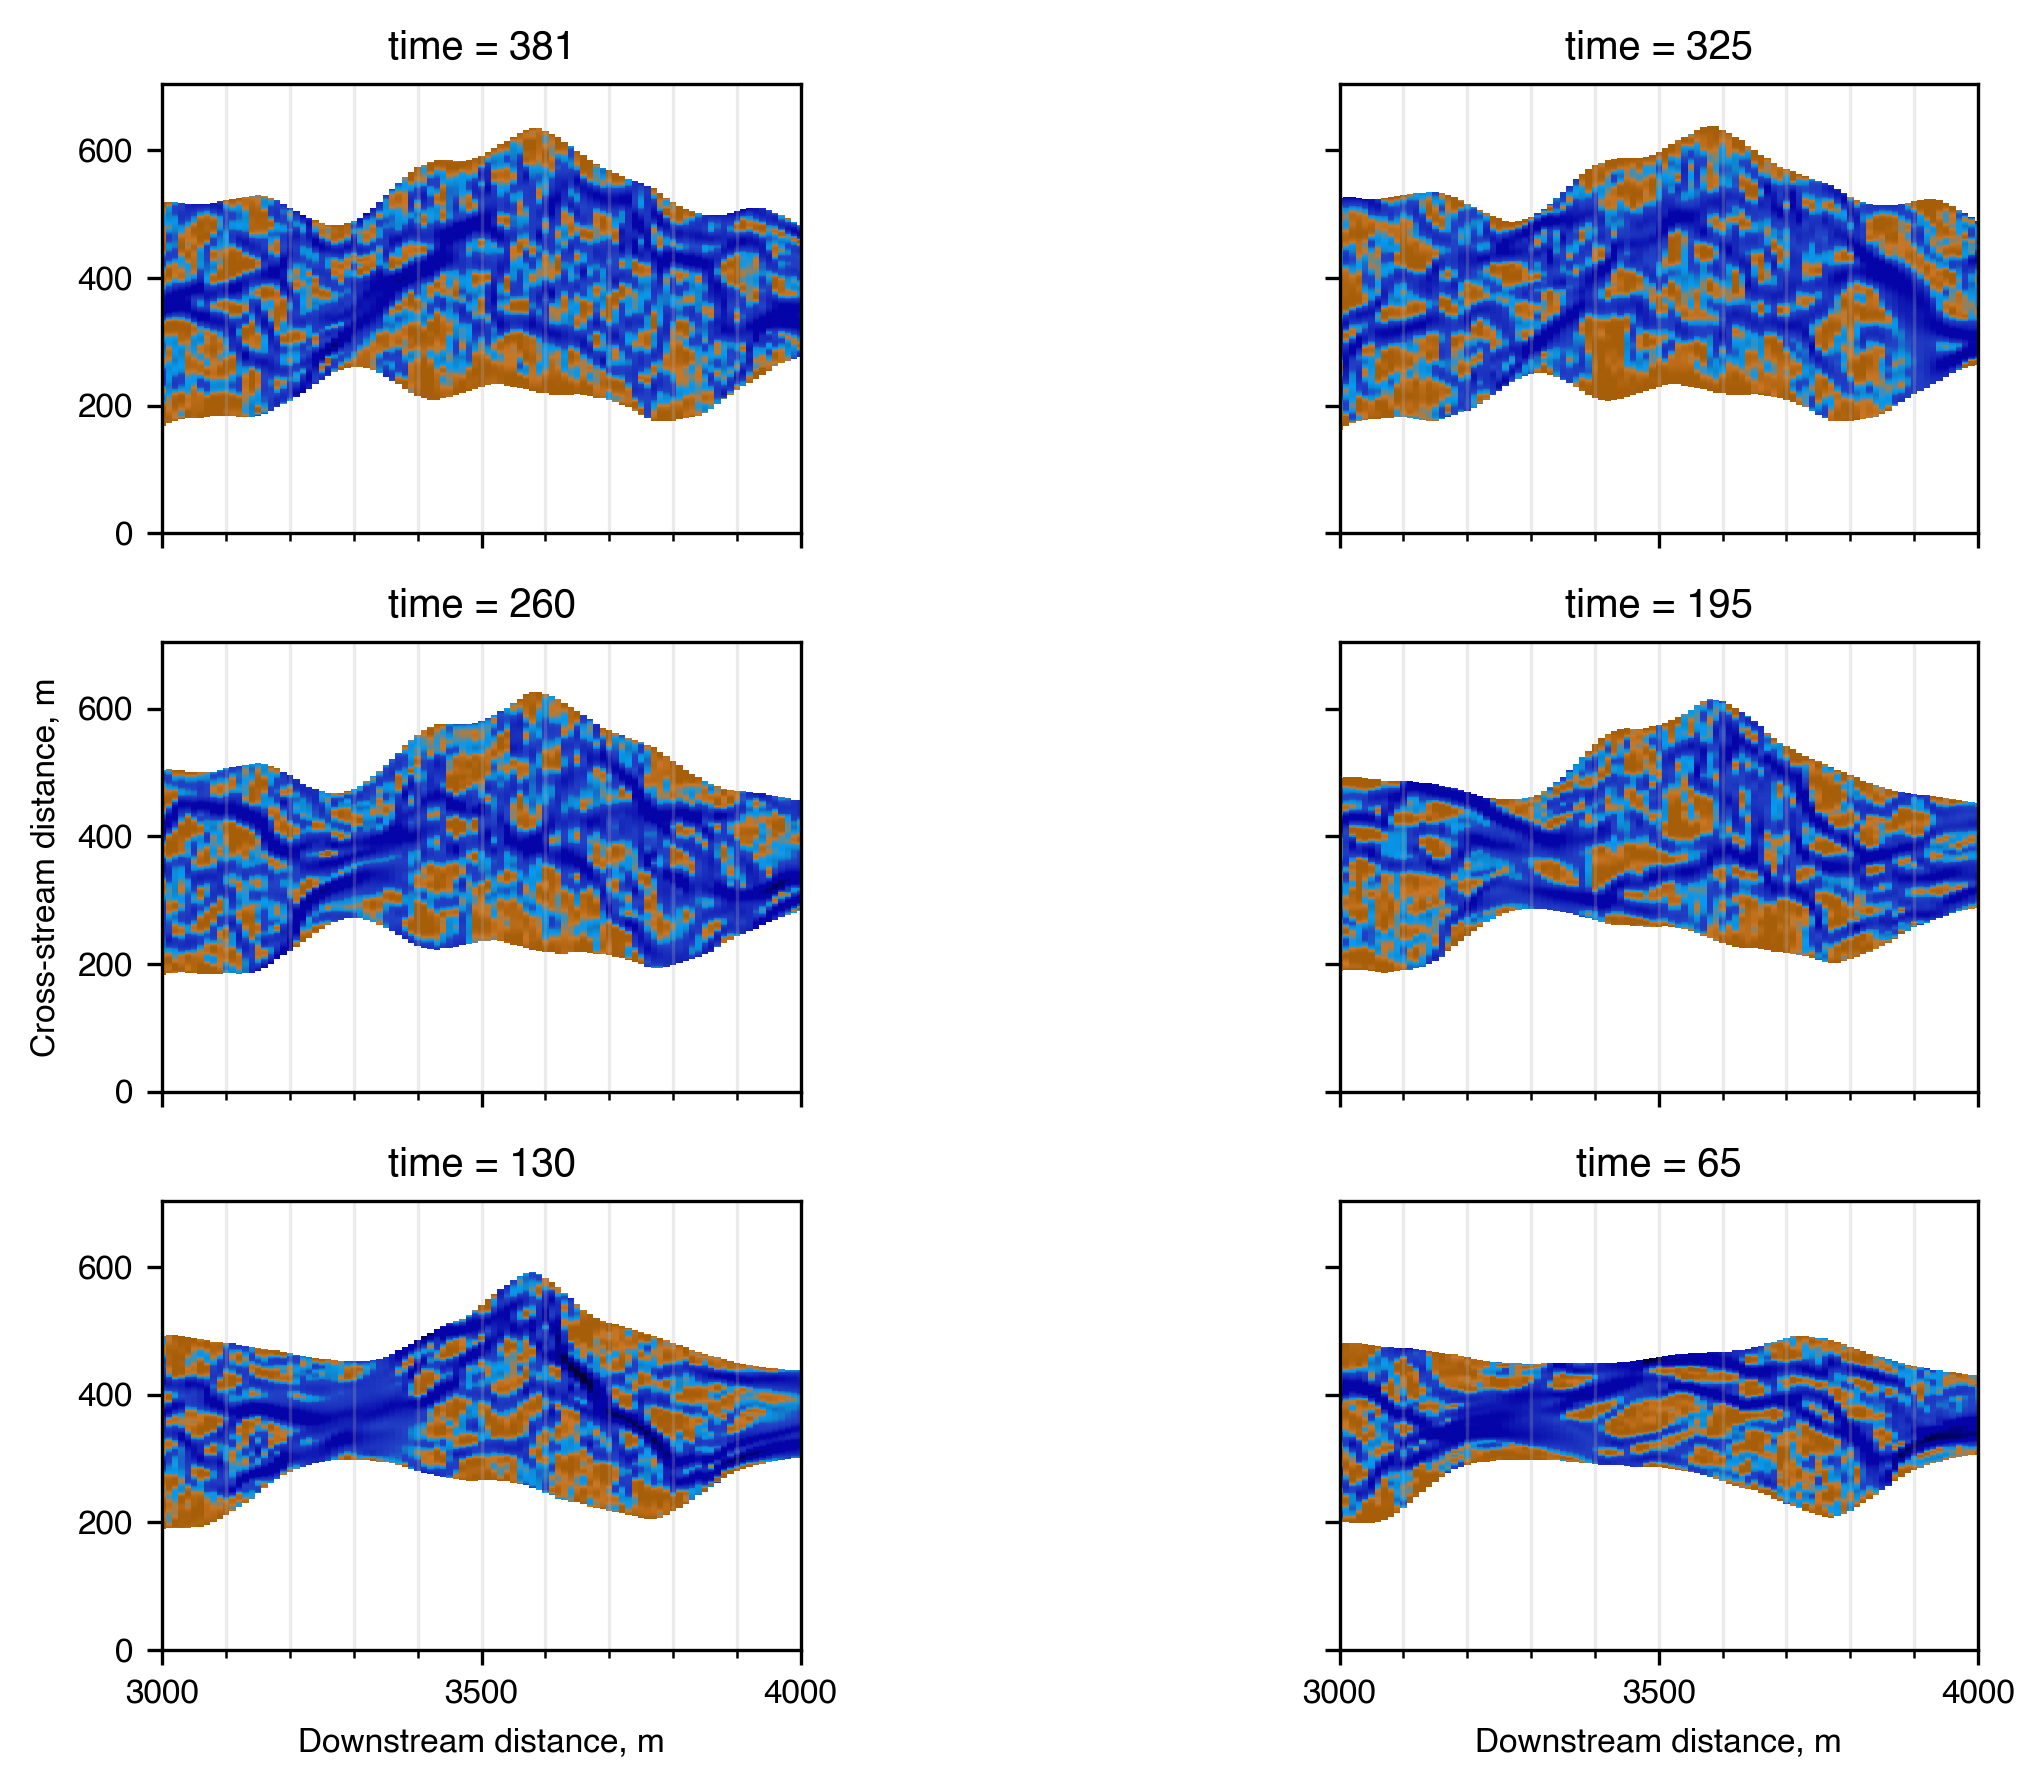

In [40]:
subs = np.append(np.arange(adjustment_time, end_t+1, adjustment_time), end_t)
fig, ax = plt.subplots(int(len(subs)/2), 2, figsize = (9, 5), dpi = 300, tight_layout = True, sharex = True, sharey = True)

ax[0, 0].set_xlim(3000, 4000)
ax[0, 0].set_ylim(hd_ylocs.min(), hd_ylocs.max())

ax[-1, 0].set_xlabel('Downstream distance, m')
ax[-1, 1].set_xlabel('Downstream distance, m')
ax[1, 0].set_ylabel('Cross-stream distance, m')
ax = ax.ravel()
for a, t in zip(ax[::-1], subs):
    a.pcolormesh(hd_xlocs[:, :, t]*10, hd_ylocs[:, :, t], hd_qw[:, :, t], cmap = get_continuous_cmap(test), norm = mcol.TwoSlopeNorm(vmin = 0, vcenter = .5, vmax = np.nanquantile(hd_qw[:, :, -1], 0.999)), shading = 'nearest')
    a.set_aspect('equal')
    a.set_title(f'time = {t}')
    a.xaxis.set_minor_locator(MultipleLocator(100))
    a.xaxis.set_major_locator(MultipleLocator(500))
    a.grid(axis = 'x', which = 'both', alpha = 0.25)
    
    